In [ ]:
import os, glob
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# River (only using ADWIN which we know works)
from river import drift as river_drift

In [ ]:
def load_individual_station_files(data_directory: str) -> pd.DataFrame:
    """Read all PRSA_Data_*.csv files, add a ``station`` column, and concatenate."""
    csv_files = glob.glob(os.path.join(data_directory, "PRSA_Data_*.csv"))
    if not csv_files:
        raise FileNotFoundError(
            f"No CSV files found in {data_directory}. "
            "Did you unzip the original PRSA2017_Data_20130301-20170228.zip?"
        )
    all_data = []
    for file in csv_files:
        parts = Path(file).stem.split('_')
        station_name = "_".join(parts[2:-1]) if len(parts) > 3 else parts[-2]
        print(f"Loading {file} (station={station_name})...")
        df = pd.read_csv(file)
        if "station" not in df.columns:
            df["station"] = station_name
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

In [ ]:
def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    mapping = {
        'PM2.5': 'PM2_5', 'PM10': 'PM10', 'SO2': 'SO2', 'NO2': 'NO2',
        'CO': 'CO', 'O3': 'O3', 'TEMP': 'TEMP', 'PRES': 'PRES',
        'DEWP': 'DEWP', 'RAIN': 'RAIN', 'wd': 'wd', 'WSPM': 'WSPM',
        'station': 'station', 'year': 'year', 'month': 'month',
        'day': 'day', 'hour': 'hour'
    }
    keep = [c for c in mapping if c in df.columns]
    return df[keep].rename(columns=mapping)

def _build_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    if not {'year', 'month', 'day', 'hour'}.issubset(df.columns):
        raise ValueError("Missing year/month/day/hour columns")
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    return df.sort_values('datetime').set_index('datetime', drop=True)

def _coerce_numeric(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def _encode_wind_direction(df: pd.DataFrame) -> pd.DataFrame:
    compass = {
        'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90,
        'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
        'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
        'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
    }
    if 'wd' in df.columns:
        wd_deg = df['wd'].map(compass)
        if wd_deg.isna().any():
            wd_deg = df['wd'].str.upper().map(compass)
        df['wd_deg'] = wd_deg
        rad = np.deg2rad(df['wd_deg'])
        df['wd_sin'] = np.sin(rad)
        df['wd_cos'] = np.cos(rad)
    return df

def _add_time_cyclic_features(df: pd.DataFrame) -> pd.DataFrame:
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['dow_sin']  = np.sin(2*np.pi*df['dayofweek']/7)
    df['dow_cos']  = np.cos(2*np.pi*df['dayofweek']/7)
    df['mon_sin']  = np.sin(2*np.pi*df['month']/12)
    df['mon_cos']  = np.cos(2*np.pi*df['month']/12)
    return df

def _hampel_filter_1d(x: pd.Series, window: int = 13, n_sigmas: float = 3.0) -> pd.Series:
    if x.isna().all():
        return x
    rolling_med = x.rolling(window, center=True).median()
    mad = (np.abs(x - rolling_med)).rolling(window, center=True).median()
    k = 1.4826
    threshold = n_sigmas * k * mad
    outlier_mask = np.abs(x - rolling_med) > threshold
    x_clean = x.copy()
    x_clean[outlier_mask] = rolling_med[outlier_mask]
    return x_clean


def fill_target(series: pd.Series, window: int = 3) -> pd.Series:
    """Fill missing values using rolling mean, forward fill, and backward fill."""
    filled = series.copy()
    rolling_mean = filled.rolling(window=window, min_periods=1, center=True).mean()
    filled = filled.fillna(rolling_mean)
    filled = filled.ffill()
    filled = filled.bfill()
    return filled



def preprocess_beijing_data(
    df: pd.DataFrame,
    *,
    remove_duplicates: bool = True,
    interpolate_numeric: bool = True,
    outlier_method: str = "hampel",
    outlier_window: int = 13,
    outlier_sigmas: float = 3.0,
    make_daily: bool = True
):
    """Returns (hourly_df, daily_df)."""
    df = _normalize_columns(df)
    
    if 'station' not in df.columns:
        raise ValueError("Column 'station' is required.")
    
    df = _build_datetime_index(df)
    
    if remove_duplicates:
        df = df[~df.index.duplicated(keep="first")]
    
    pollutant_cols = [c for c in ['PM2_5','PM10','SO2','NO2','CO','O3'] if c in df.columns]
    weather_cols   = [c for c in ['TEMP','PRES','DEWP','RAIN','WSPM'] if c in df.columns]
    num_cols = pollutant_cols + weather_cols
    
    df = _coerce_numeric(df, num_cols)
    
    if pollutant_cols:
        df = df.dropna(subset=pollutant_cols, how='all')
    
    if interpolate_numeric and num_cols:
        df = (
            df.sort_index()
            .groupby('station', group_keys=False)
            .apply(lambda g: g.assign(**{
                c: g[c].interpolate(method='time', limit_direction='both')
                for c in num_cols
            }))
        )
        df[num_cols] = (
            df[num_cols]
            .groupby(df['station']).ffill()
            .groupby(df['station']).bfill()
        )
    
    if 'wd' in df.columns:
        df['wd'] = df.groupby('station')['wd'].ffill().groupby(df['station']).bfill()
    
    df = _encode_wind_direction(df)
    df = _add_time_cyclic_features(df)
    
    if outlier_method == "hampel" and num_cols:
        def _clean(g):
            for c in num_cols:
                g[c] = _hampel_filter_1d(g[c],
                                         window=outlier_window,
                                         n_sigmas=outlier_sigmas)
            return g
        df = df.groupby('station', group_keys=False).apply(_clean)
    
    daily_df = None
    if make_daily:
        numeric = df[num_cols + [c for c in df.columns if c.endswith(('_sin','_cos'))]].copy()
        daily_df = (
            numeric
            .groupby(df['station'])
            .resample('D')
            .mean(numeric_only=True)
            .reset_index()
            .set_index('datetime')
            .sort_index()
        )
    
    df = df.sort_index()
    return df, daily_df

In [ ]:
# feature engineering
def create_basic_features(daily_df: pd.DataFrame, target: str = "PM2_5") -> pd.DataFrame:
    """Create basic lag and rolling features."""
    enhanced_df = daily_df.copy()
    
    # Simple lag features
    for lag in [1, 3, 7]:
        enhanced_df[f'{target}_lag_{lag}'] = (
            enhanced_df.groupby('station')[target].shift(lag)
        )
    
    # Simple rolling features
    for window in [7, 14]:
        enhanced_df[f'{target}_roll_mean_{window}'] = (
            enhanced_df.groupby('station')[target]
            .transform(lambda x: x.rolling(window, min_periods=1).mean())
        )
    
    return enhanced_df

In [4]:
# drift detection (using only ADWIN)
def simple_drift_detection(
    daily_df: pd.DataFrame,
    target: str = "PM2_5",
    delta: float = 0.002,
    drift_cooldown: pd.Timedelta = pd.Timedelta(days=30),
):
    """
    Simplified drift detection using only ADWIN.
    """
    detectors = defaultdict(lambda: river_drift.ADWIN(delta=delta))
    last_change = defaultdict(lambda: pd.NaT)
    
    station_drifts = defaultdict(list)
    
    for ts, row in daily_df.iterrows():
        station = row["station"]
        y = row[target]
        
        if pd.isna(y):
            continue
            
        det = detectors[station]
        det.update(y)
        
        if hasattr(det, "drift_detected") and det.drift_detected:
            if pd.isna(last_change[station]) or (ts - last_change[station] > drift_cooldown):
                print(f"[{ts.date()}] ADWIN drift @ station `{station}`")
                station_drifts[station].append(ts)
                last_change[station] = ts
    
    # Format results
    results = {}
    for station in daily_df['station'].unique():
        results[station] = {
            "change_points": station_drifts[station],
            "method_detections": {"adwin": station_drifts[station]}
        }
    
    return results




In [3]:
# forecaster
class SimpleForecaster:
    """Simplified forecaster focusing on SARIMAX."""
    
    def __init__(self, target='PM2_5'):
        self.target = target
        self.models = {}
        
    def fit_regime_models(self, daily_df: pd.DataFrame, station: str, change_points: list):
        """Fit SARIMAX models for each regime."""
        station_data = daily_df[daily_df['station'] == station][self.target]
        
        # Define regime boundaries
        bounds = [station_data.index.min()] + sorted(change_points) + [station_data.index.max()]
        regimes = [(bounds[i], bounds[i + 1]) for i in range(len(bounds) - 1)]
        
        regime_models = []
        
        for i, (start, end) in enumerate(regimes, 1):
            regime_data = station_data.loc[start:end].dropna()
            
            if len(regime_data) < 50:  # Need sufficient data
                continue
            
            try:
                # Fit SARIMAX
                sarimax = SARIMAX(
                    regime_data,
                    order=(1, 1, 1),  # Simpler order to avoid convergence issues
                    seasonal_order=(1, 0, 1, 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                
                fit = sarimax.fit(disp=False, maxiter=100)
                
                regime_models.append({
                    "regime_id": i,
                    "start": start,
                    "end": end,
                    "aic": fit.aic,
                    "model": fit,
                    "data_points": len(regime_data)
                })
                
                print(f"  Fitted regime {i}: {start.date()} → {end.date()}, AIC={fit.aic:.2f}, n={len(regime_data)}")
                
            except Exception as e:
                print(f"  Failed to fit regime {i}: {e}")
                continue
        
        self.models[station] = regime_models
        return regime_models
    
    def forecast(self, station: str, steps: int = 30):
        """Generate forecasts using the latest regime model."""
        if station not in self.models or not self.models[station]:
            raise ValueError(f"No models available for station {station}")
        
        # Use the latest (most recent) regime model
        latest_model = self.models[station][-1]
        model = latest_model['model']
        
        try:
            forecast_result = model.get_forecast(steps=steps)
            forecasts = forecast_result.predicted_mean
            
            # Add confidence intervals
            conf_int = forecast_result.conf_int()
            
            return {
                'forecast': forecasts,
                'conf_int_lower': conf_int.iloc[:, 0],
                'conf_int_upper': conf_int.iloc[:, 1],
                'regime_info': latest_model
            }
        except Exception as e:
            print(f"Forecast failed: {e}")
            return None

In [5]:
def plot_simple_analysis(daily_df: pd.DataFrame, station: str, drift_results: dict, forecast_result: dict = None):
    """Simple but effective visualization."""
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    station_data = daily_df[daily_df['station'] == station]
    
    # Plot 1: Time series with drift points and forecast
    axes[0].plot(station_data.index, station_data['PM2_5'], 'b-', label='Observed PM2.5', alpha=0.7)
    
    change_points = drift_results[station]['change_points']
    for i, cp in enumerate(change_points):
        label = 'Drift Points' if i == 0 else ""
        axes[0].axvline(cp, color='red', linestyle='--', alpha=0.8, label=label)
    
    if forecast_result:
        forecast = forecast_result['forecast']
        axes[0].plot(forecast.index, forecast.values, 'g-', linewidth=2, label='Forecast')
        
        # Add confidence intervals
        axes[0].fill_between(
            forecast.index,
            forecast_result['conf_int_lower'],
            forecast_result['conf_int_upper'],
            alpha=0.3, color='green', label='95% Confidence'
        )
    
    axes[0].set_title(f'{station} - PM2.5 Time Series Analysis')
    axes[0].set_ylabel('PM2.5 (μg/m³)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Recent data focus (last 6 months + forecast)
    recent_start = station_data.index.max() - pd.Timedelta(days=180)
    recent_data = station_data.loc[recent_start:]
    
    axes[1].plot(recent_data.index, recent_data['PM2_5'], 'b-', label='Recent Observed', linewidth=1.5)
    
    if forecast_result:
        forecast = forecast_result['forecast']
        axes[1].plot(forecast.index, forecast.values, 'g-', linewidth=2, label='30-day Forecast')
        axes[1].fill_between(
            forecast.index,
            forecast_result['conf_int_lower'],
            forecast_result['conf_int_upper'],
            alpha=0.3, color='green'
        )
    
    axes[1].set_title(f'{station} - Recent Data & Forecast')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('PM2.5 (μg/m³)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv (station=Gucheng)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Huairou_20130301-20170228.csv (station=Huairou)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Tiantan_20130301-20170228.csv (station=Tiantan)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv (station=Changping)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv (station=Guanyuan)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/dat

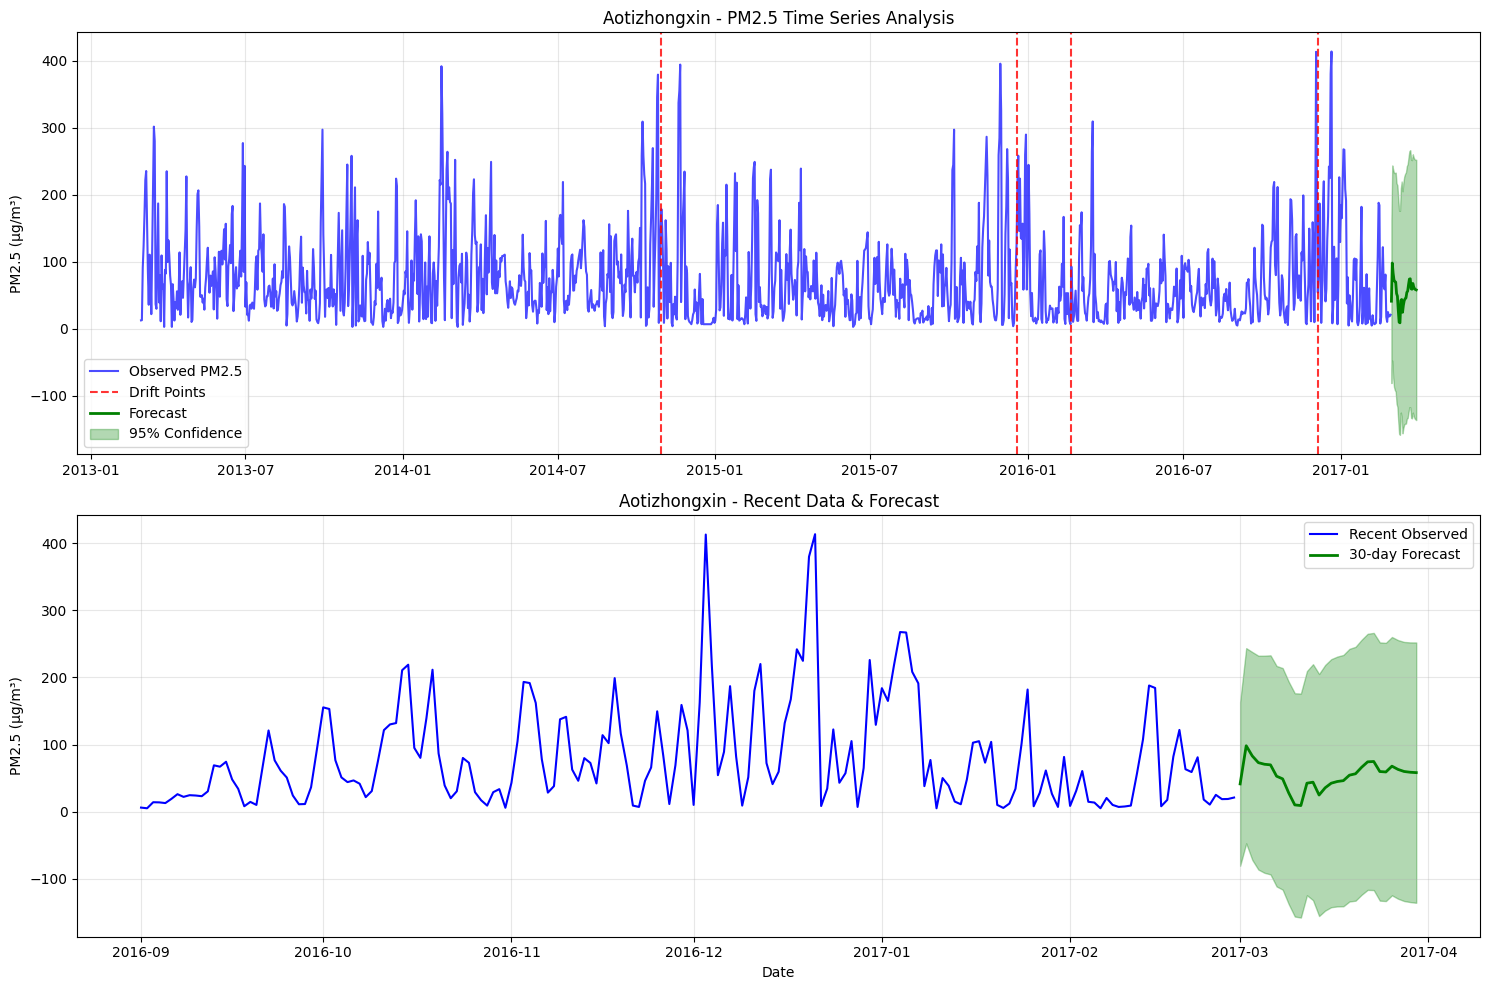


Baseline evaluation (last 30 days):
  Baseline SARIMAX MAE: 49.5579

Pipeline completed successfully!


In [8]:
def main_simple():
    """Simplified main function that should work without errors."""
    
    # Load and preprocess data
    data_dir = "/Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228"
    
    try:
        raw_df = load_individual_station_files(data_dir)
        print(f"\nRaw shape: {raw_df.shape}")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please update the data_dir path to point to your Beijing data directory.")
        return None, None, None, None
    
    # Preprocess
    hourly_df, daily_df = preprocess_beijing_data(
        raw_df,
        remove_duplicates=True,
        interpolate_numeric=True,
        outlier_method="hampel",
        make_daily=True,
    )
    
    print(f"Hourly shape: {hourly_df.shape}")
    print(f"Daily shape: {daily_df.shape}")
    
    # Fill missing target values
    daily_df['PM2_5'] = (
        daily_df
        .groupby('station')['PM2_5']
        .transform(lambda s: fill_target(s, window=7))
    )
    
    # Add basic features
    daily_df = create_basic_features(daily_df, target="PM2_5")
    print(f"Enhanced daily shape: {daily_df.shape}")
    
    # Simple drift detection (only ADWIN)
    print("\nRunning drift detection (ADWIN only)...")
    drift_results = simple_drift_detection(
        daily_df,
        target="PM2_5",
        delta=0.002,
        drift_cooldown=pd.Timedelta(days=30)
    )
    
    # Initialize forecaster
    forecaster = SimpleForecaster(target="PM2_5")
    
    # Work with a specific station
    station = "Aotizhongxin"
    change_points = drift_results[station]['change_points']
    
    print(f"\nAnalyzing station: {station}")
    print(f"Detected {len(change_points)} drift points:")
    for cp in change_points:
        print(f"  - {cp.date()}")
    
    # Fit regime models
    print(f"\nFitting regime models...")
    regime_models = forecaster.fit_regime_models(daily_df, station, change_points)
    
    # Generate forecast
    forecast_result = None
    if regime_models:
        print(f"\nGenerating 30-day forecast...")
        forecast_result = forecaster.forecast(station, steps=30)
        
        if forecast_result:
            forecast = forecast_result['forecast']
            print(f"Forecast range: {forecast.min():.2f} - {forecast.max():.2f} μg/m³")
            print(f"Forecast mean: {forecast.mean():.2f} μg/m³")
    
    # Visualization
    plot_simple_analysis(daily_df, station, drift_results, forecast_result)
    
    # Basic evaluation (using last 30 days as test)
    station_data = daily_df[daily_df['station'] == station]['PM2_5']
    train_data = station_data[:-30]
    test_data = station_data[-30:]
    
    if len(train_data) > 100 and len(test_data) > 0:
        print(f"\nBaseline evaluation (last 30 days):")
        
        # Simple SARIMAX baseline
        try:
            baseline_model = SARIMAX(
                train_data,
                order=(1, 1, 1),
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            baseline_fit = baseline_model.fit(disp=False)
            baseline_pred = baseline_fit.get_forecast(steps=len(test_data)).predicted_mean
            baseline_mae = mean_absolute_error(test_data, baseline_pred)
            
            print(f"  Baseline SARIMAX MAE: {baseline_mae:.4f}")
            
        except Exception as e:
            print(f"  Baseline evaluation failed: {e}")
    
    return hourly_df, daily_df, drift_results, forecaster

if __name__ == "__main__":
    try:
        hourly_df, daily_df, drift_results, forecaster = main_simple()
        print("\nPipeline completed successfully!")
        
    except Exception as e:
        print(f"\nError in main execution: {e}")
        import traceback
        traceback.print_exc()